In [106]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.optimize import minimize

In [25]:
def log_post_odds(x, sigma, sigma_s, prior_log):
    c1 = norm.logcdf(x * sigma_s / sigma / np.sqrt(sigma_s**2 + sigma**2))
    c2 = norm.logcdf(-x * sigma_s / sigma / np.sqrt(sigma_s**2 + sigma**2))
    return prior_log + c1 - c2
def target_func(sigma, sigma_s, prior_log):
    my_func = lambda x: abs(log_post_odds(x, sigma, sigma_s, prior_log))
    res = minimize(my_func, 0)
    return res.x


array([-0.12586661])

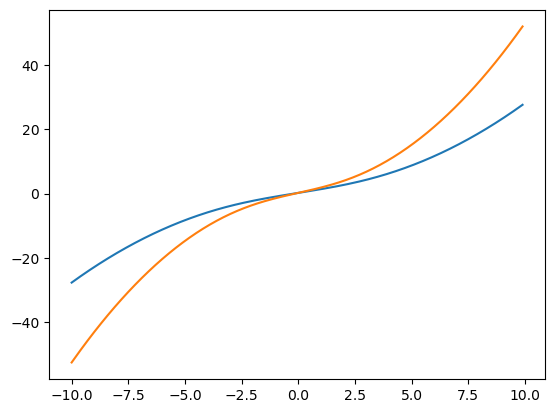

In [30]:
sigma, sigma_s, prior_log = 1, 1, 0.2
x = np.arange(-10, 10, 0.1)
plt.plot(x, log_post_odds(x, sigma, sigma_s, prior_log))
target_func(sigma, sigma_s, prior_log)
sigma, sigma_s, prior_log = 1, 10, 0.2
x = np.arange(-10, 10, 0.1)
plt.plot(x, log_post_odds(x, sigma, sigma_s, prior_log))
target_func(sigma, sigma_s, prior_log)

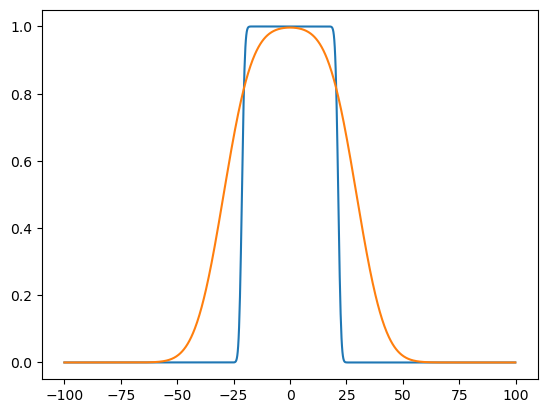

In [54]:
sigma, sigma1, sigma2 = 1, 9, 144
def cal_lamb(sigma, sigma1, sigma2):
    var1 = sigma**2 + sigma1**2
    var2 = sigma**2 + sigma2**2
    lamb = np.sqrt(np.log(var2/var1)/(1/var1-1/var2))
    return lamb
def cal_p1(sigma, sigma1, sigma2):
    lamb = cal_lamb(sigma, sigma1, sigma2)
    s = np.arange(-100, 100,0.2)
    return norm.cdf((lamb - s)/sigma) - norm.cdf((-lamb-s)/sigma)
def cal_roc(sigma, sigma1, sigma2):
    lamb = cal_lamb(sigma, sigma1, sigma2)
    H = -1 + 2 * norm.cdf(lamb / np.sqrt(sigma**2 + sigma1**2))
    F = -1 + 2 * norm.cdf(lamb / np.sqrt(sigma**2 + sigma2**2))
    C = (H + 1 - F)/2
    return H, F, C
plt.plot(s, cal_p1(1, 9, 144))
plt.plot(s, cal_p1(10, 9, 144))

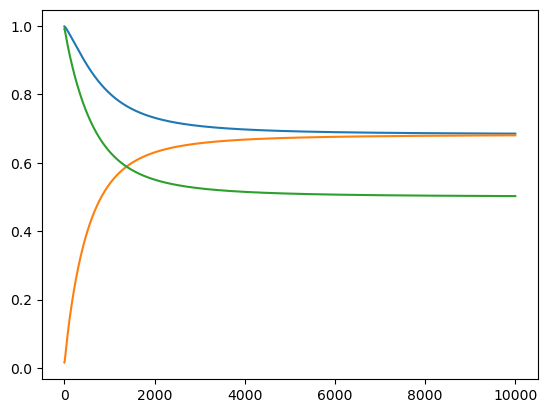

In [59]:
sigma = np.arange(0, 10000, 1)
H, F, C = cal_roc(sigma, 9, 1444)
plt.plot(sigma, H)
plt.plot(sigma, F)
plt.plot(sigma, C)

In [83]:
def gen_cat(p, n):
    rng = np.random.default_rng(42)
    return rng.binomial(n = 1, p = p, size = n)

def gen_sti(cat, sigma_s):
    rng = np.random.default_rng(42)
    dev = rng.normal(loc = 0, scale = sigma_s, size = cat.shape)
    return abs(dev) * (2 * cat - 1)

def gen_mea(sti, sigma):
    rng = np.random.default_rng(42)
    dev = rng.normal(loc = 0, scale = sigma, size = (sti.shape[0], sti.shape[1], len(sigma)))
    return sti[:, :, np.newaxis] + dev



plist = np.arange(0.1, 1.1, 0.2).reshape(-1, 1)
cat = gen_cat(plist, (len(plist), 100000))
sti = gen_sti(cat, 1)
mea = gen_mea(sti, np.array([0.5, 1, 2]))

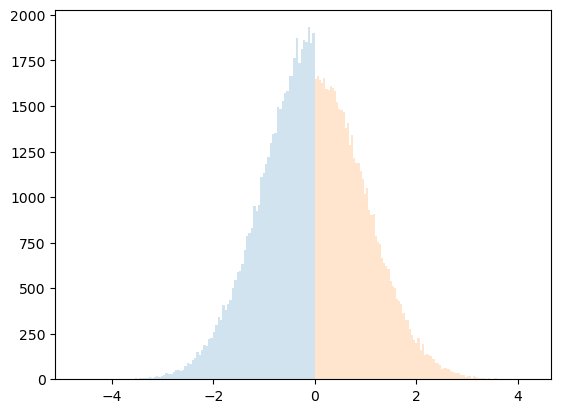

In [77]:
plt.hist(sti[2, cat[2] == 0],bins = 100, alpha = 0.2)
plt.hist(sti[2, cat[2] == 1],bins = 100, alpha = 0.2)
plt.show()

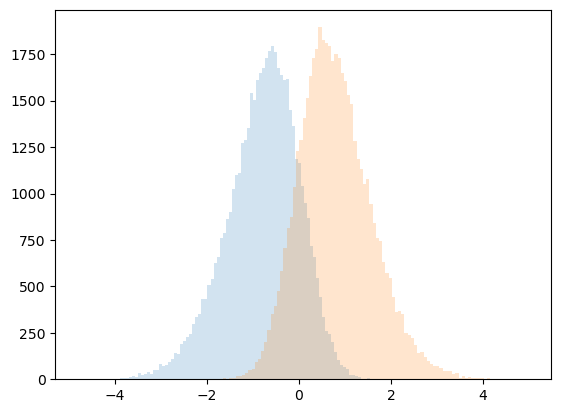

In [76]:
plt.hist(mea[2, cat[2] == 0, 0],bins = 100, alpha = 0.2)
plt.hist(mea[2, cat[2] == 1, 0],bins = 100, alpha = 0.2)
plt.show()

In [100]:
def best(sigma, sigma_s, prior):
    def loglik(x, sigma, sigma_s, prior):
        z = sigma_s * x / sigma / np.sqrt(sigma**2 + sigma_s**2)
        return np.log(prior/(1-prior)) + np.log(norm.cdf(z)/norm.cdf(-z))
    my_func = lambda x: abs(loglik(x, sigma, sigma_s, prior))
    res = minimize(my_func, 0)
    return res.x

def simu(mea, cat, thres):
    H = ((mea > thres) * (cat == 1)).mean()
    F = ((mea > thres) * (cat == 0)).mean()
    C = ((mea > thres) * (cat == 1) + (mea < thres) * (cat == 0)).mean()
    return H, F, C

best(1, 1, 0.3)

array([0.74161431])

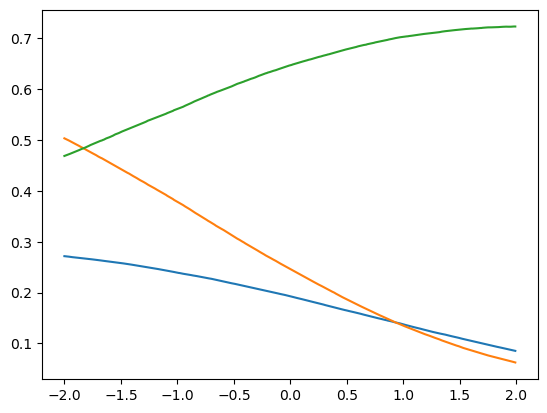

In [105]:
Cs = [simu(mea[1, :, 2], cat[1], thres) for thres in np.arange(-2, 2, 0.01)]
plt.plot(np.arange(-2, 2, 0.01), Cs)

In [97]:
cat.mean(1)
cat.shape
((cat == 1) * (mea[:, :, 1] > 0.7)).mean(1) + ((cat == 0) * (mea[:, :, 1] < 0.7)).mean(1)

array([0.86462, 0.78798, 0.71483, 0.64073, 0.56318])

## 8.11

In [150]:
data = pd.read_csv('./Data/psycho.csv')
pre, rep = np.array(data.pre), np.array(data.rep, dtype = np.int8)
psy_curve = data.groupby('pre').rep.mean()

In [154]:
def loglik(sigma, pre, rep):
    z = pre * (2 * rep - 1) / sigma
    return norm.logcdf(z).sum()

sigma = np.arange(0.1, 5, 0.01).reshape(-1, 1)
res = minimize(lambda sigma: -loglik(sigma, pre, rep), 1)
sigma_hat = res.x
res.fun


157.1883972626036

In [159]:
def loglik2(theta, pre, rep):
    sigma, lamb = theta
    z = pre * (2 * rep - 1) / sigma
    p = norm.cdf(z) * (1-lamb) + 0.5 * lamb
    return np.log(p).sum()

res2 = minimize(lambda sigma: -loglik2(sigma, pre, rep), (1, 0))
theta_hat = res2.x
res2.x, res2.fun

(array([1.45581891, 0.05270736]), 152.56326982738307)

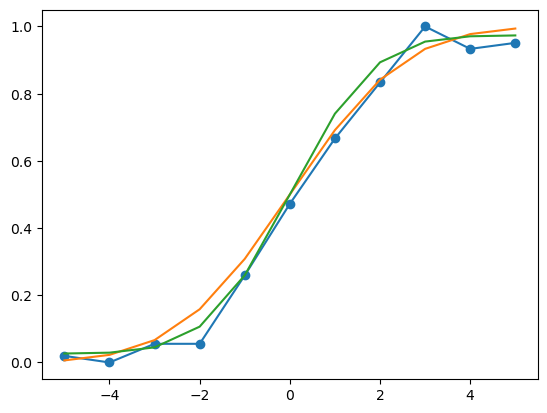

In [160]:
plt.plot(psy_curve.index, psy_curve, '-o')
x = np.arange(-5, 6)
plt.plot(x, norm.cdf(x/sigma_hat))
plt.plot(x, norm.cdf(x/theta_hat[0])* (1 - theta_hat[1]) + 0.5 * theta_hat[1])